In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as mlt
import seaborn as sp
from torch.autograd import Variable
from torch import autograd
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import timedelta
import sys
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from scipy.stats import ks_2samp
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [1698]:
%run ../Pre_process/Data_preprocess.ipynb
%run Model/Mogrifier_LSTM.ipynb
%run Model/Bi_LSTM.ipynb
%run Model/LSTM.ipynb
%run train.ipynb
%run ../visualize.ipynb
%run test.ipynb
%run ../validation.ipynb

In [1673]:
#df = pd.read_csv(processed_data_csv)
#df.drop(columns=['Start', 'Year', 'Day of week', 'Week Day', 'Month', 'Day of month'], inplace=True)
#df1 = pd.read_csv(processed_data_csv)
data1 = pd.read_csv("../Data/Processed/acn_data_with_zero.csv")
data2 = pd.read_csv("../Data/Processed/palo_alto_data_with_zero.csv")
data3 = pd.read_csv("../Data/Processed/boulder_data_with_zero.csv")
data3 = data3.loc[(data3['Start'] >= '2019-01-01 00:00:00') & (data3['Start'] <= '2019-12-31 23:00:00')]
data2 = data2.loc[(data2['Start'] >= '2017-01-01 00:00:00') & (data2['Start'] <= '2018-01-01 23:00:00')]
data1 = data1.loc[(data1['Start'] >= '2018-01-02 00:00:00') & (data1['Start'] <= '2018-12-31 23:00:00')]
df = pd.concat([data2, data1, data3], axis=0).reset_index(drop=True)
#df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
df['Hour'] = pd.to_datetime(df['Start']).dt.hour
df.drop(columns=['Start'], inplace=True)
#df.drop(columns=['Start', 'Year', 'Day of week', 'Week Day', 'Month', 'Day of month'], inplace=True)
input_size = df.shape[1]

In [1674]:
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Hour'])
#df = pd.DataFrame(df, columns=['Energy'])

In [1675]:
data_train, data_test, ground_truth_train, ground_truth_test = get_train_test_dataset_forecasting(df, train_ratio)

In [1676]:
step_per_epoch = len(data_train) // batch_size

# Converting to tensor
data_train = torch.from_numpy(data_train).float().to(device)
ground_truth_train = torch.from_numpy(ground_truth_train).float().to(device)


# Mogrifier LSTM

Trainning------------------------------------------------------------------------------------------------------------------------------

In [1588]:
hidden_size = 6
model = Mogrifier_LSTM(input_size, hidden_size, 1, batch_size).to(device)
#model = Seq2SeqAttention(input_size, hidden_size, input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.0001)
loss_function_mogrifier = nn.MSELoss()

In [1589]:
real_dataset_mogrifier, gen_dataset_mogrifier, errors_generator_mogrifier = train_mogrifier_lstm(model, optimizer, loss_function_mogrifier, data_train, ground_truth_train, step_per_epoch)

Epoch: 0 Loss G.: 1.102786898612976
Epoch: 1 Loss G.: 0.9434794783592224
Epoch: 2 Loss G.: 0.8774840235710144
Epoch: 3 Loss G.: 0.9677995443344116
Epoch: 4 Loss G.: 0.9389605522155762
Epoch: 5 Loss G.: 0.7037234902381897
Epoch: 6 Loss G.: 0.5349811315536499
Epoch: 7 Loss G.: 0.4525826871395111
Epoch: 8 Loss G.: 0.40953192114830017
Epoch: 9 Loss G.: 0.3811560571193695
Epoch: 10 Loss G.: 0.3615371286869049
Epoch: 11 Loss G.: 0.34761300683021545
Epoch: 12 Loss G.: 0.3359450101852417
Epoch: 13 Loss G.: 0.3245737850666046
Epoch: 14 Loss G.: 0.31325986981391907
Epoch: 15 Loss G.: 0.30069422721862793
Epoch: 16 Loss G.: 0.2873787581920624
Epoch: 17 Loss G.: 0.27384015917778015
Epoch: 18 Loss G.: 0.2606155574321747
Epoch: 19 Loss G.: 0.24819526076316833
Epoch: 20 Loss G.: 0.2365856021642685
Epoch: 21 Loss G.: 0.22613832354545593
Epoch: 22 Loss G.: 0.2167833298444748
Epoch: 23 Loss G.: 0.20890109241008759
Epoch: 24 Loss G.: 0.20189672708511353
Epoch: 25 Loss G.: 0.19600561261177063
Epoch: 26 Los

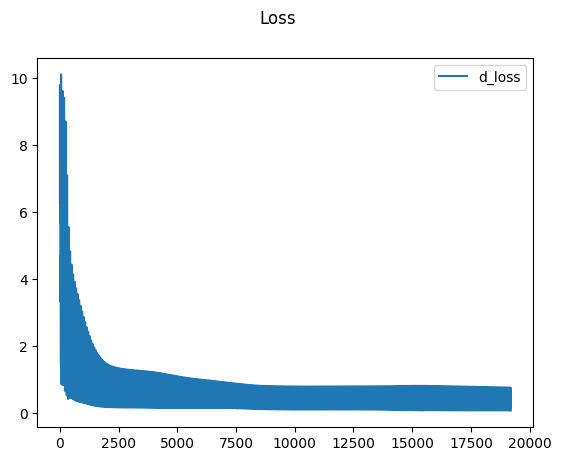

In [1590]:
mlt.suptitle('Loss')
mlt.plot(errors_generator_mogrifier, label='d_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

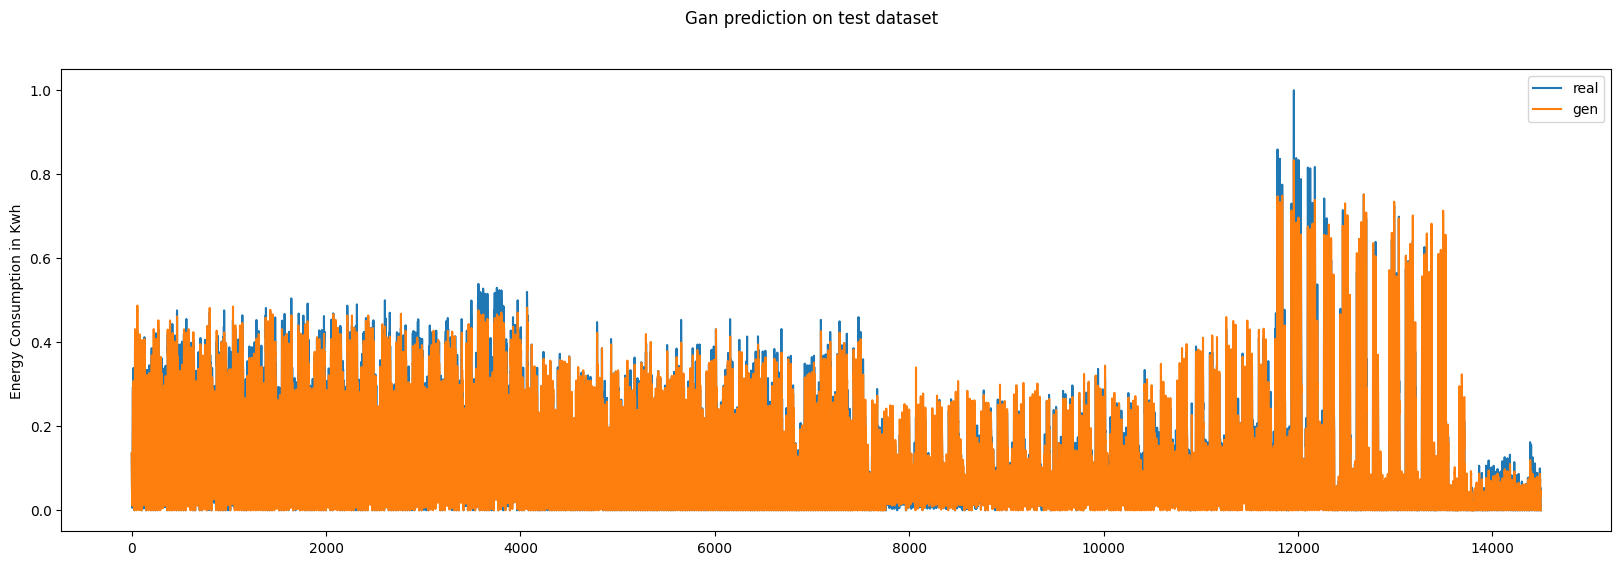

In [1591]:
plot_full_dataset(real_dataset_mogrifier[:].detach().cpu().numpy(), gen_dataset_mogrifier[:].detach().cpu().numpy(), 1000, 15500, 'Results/test1.png', 0)

Testing-------------------------------------------------------------------------------------------------------------------------------

In [1574]:
df = pd.read_csv("../Data/Processed/acn_data_with_zero.csv")
#df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
df['Hour'] = pd.to_datetime(df['Start']).dt.hour
df.drop(columns=['Start'], inplace=True)
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Hour'])

In [1575]:

_, data_test, _, ground_truth_test = get_train_test_dataset_forecasting(df, train_ratio)

In [1592]:
data_test = data_test[: -(data_test.shape[0] % batch_size)]
ground_truth_test = ground_truth_test[: -(ground_truth_test.shape[0] % batch_size)]

In [1593]:
step_per_epoch = len(data_test) // batch_size

In [1594]:
# tr = df['Energy']
# mlt.figure(figsize=(20, 6))
# mlt.suptitle('Gan prediction on test dataset')
# mlt.ylabel('Energy Consumption in Kwh')
# mlt.plot(tr, label='real')
# mlt.legend()
# mlt.show()

In [1595]:
data_test = torch.from_numpy(data_test).float().to(device)
ground_truth_test = torch.from_numpy(ground_truth_test).float().to(device)

In [1596]:
real_dataset_test_mogrifier, predicted_dataset_mogrifier, loss = test_model(model, data_test, ground_truth_test, loss_function_mogrifier, step_per_epoch)

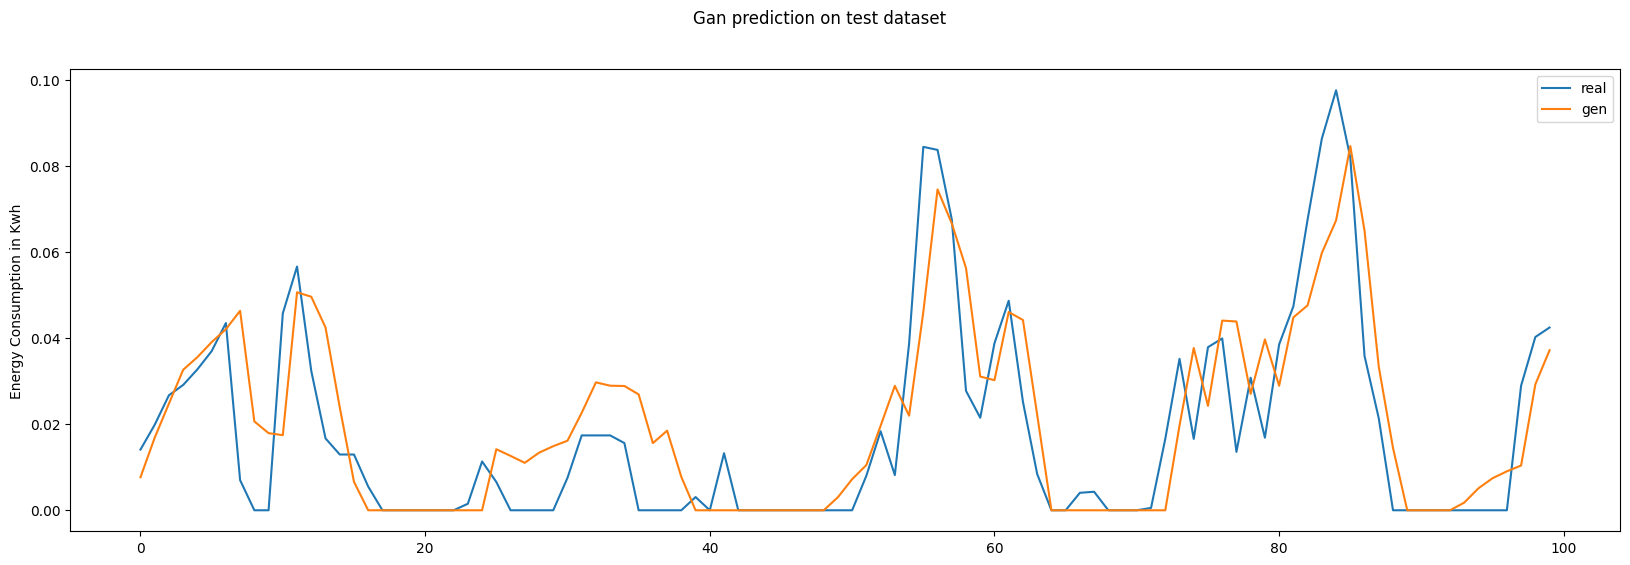

In [1602]:
plot_full_dataset(real_dataset_test_mogrifier.detach().cpu().numpy(), predicted_dataset_mogrifier.detach().cpu().numpy(), 000, 100, 'Results/test3.png', 0)

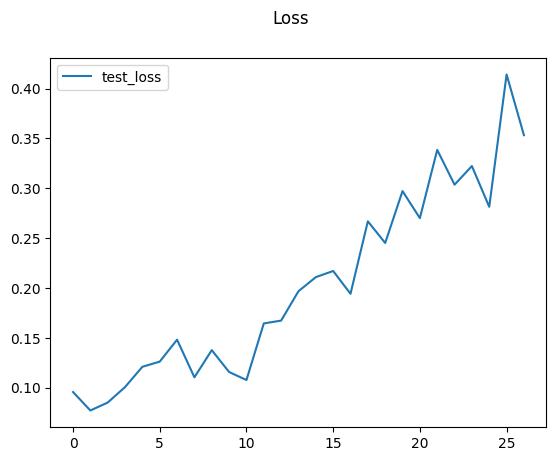

In [1598]:
mlt.suptitle('Loss')
#mlt.plot(errors_generator, label='train_loss')
mlt.plot(loss[:], label='test_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

Evaluation----------------------------------------------------------------------------------------------------------------

In [1599]:
validation_matrix_forecasting(real_dataset_test_mogrifier.detach().cpu().numpy(), predicted_dataset_mogrifier.detach().cpu().numpy(), 0)

RMSE:0.02806948684155941
MAE: 0.018949484
MSE: 0.00078789605
R-squared: 0.34245646630738213


# Bi LSTM

In [1647]:
hidden_size = 14
model = Bi_LSTM(input_size, hidden_size, 1).to(device)
#model = Seq2SeqAttention(input_size, hidden_size, input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.0001)
loss_function_bilstm = nn.MSELoss()

In [1648]:
real_dataset_bilstm, gen_dataset_bilstm, errors_generator_bilstm = train_bi_lstm(model, optimizer, loss_function_bilstm, data_train, ground_truth_train, step_per_epoch)

Epoch: 0 Loss G.: 1.6417351961135864
Epoch: 1 Loss G.: 1.9834742546081543
Epoch: 2 Loss G.: 0.4510766267776489
Epoch: 3 Loss G.: 0.4350450038909912
Epoch: 4 Loss G.: 0.3610784709453583
Epoch: 5 Loss G.: 0.39540332555770874
Epoch: 6 Loss G.: 0.3884742558002472
Epoch: 7 Loss G.: 0.4129515588283539
Epoch: 8 Loss G.: 0.39944788813591003
Epoch: 9 Loss G.: 0.33114883303642273
Epoch: 10 Loss G.: 0.23737521469593048
Epoch: 11 Loss G.: 0.2293204963207245
Epoch: 12 Loss G.: 0.24089699983596802
Epoch: 13 Loss G.: 0.2598126530647278
Epoch: 14 Loss G.: 0.2539343237876892
Epoch: 15 Loss G.: 0.24659831821918488
Epoch: 16 Loss G.: 0.24464111030101776
Epoch: 17 Loss G.: 0.2504671812057495
Epoch: 18 Loss G.: 0.27768367528915405
Epoch: 19 Loss G.: 0.3048374652862549
Epoch: 20 Loss G.: 0.31655749678611755
Epoch: 21 Loss G.: 0.2951407730579376
Epoch: 22 Loss G.: 0.2717750668525696
Epoch: 23 Loss G.: 0.2557932436466217
Epoch: 24 Loss G.: 0.2516103684902191
Epoch: 25 Loss G.: 0.2499171644449234
Epoch: 26 Los

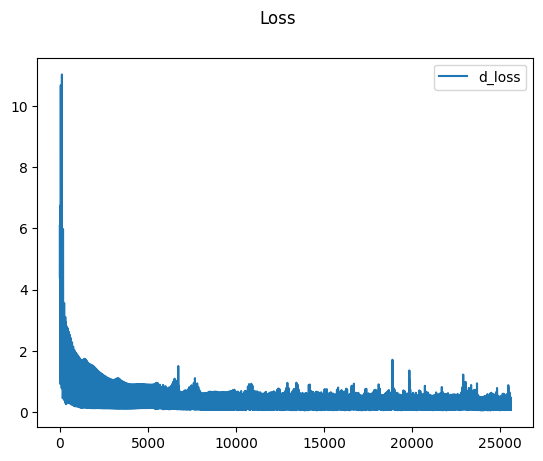

In [1649]:
mlt.suptitle('Loss')
mlt.plot(errors_generator_bilstm, label='d_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

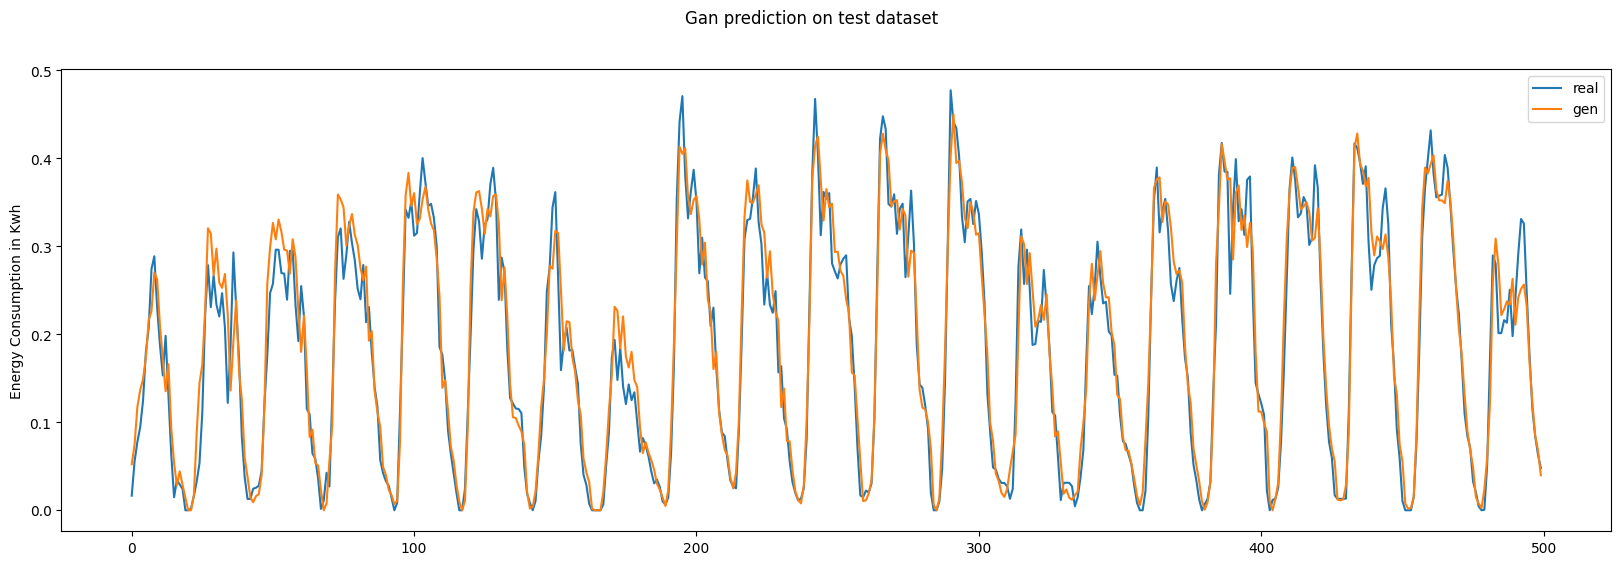

In [1650]:
plot_full_dataset(real_dataset_bilstm[:].detach().cpu().numpy(), gen_dataset_bilstm[:].detach().cpu().numpy(), 00, 500, 'Results/test1.png', 0)

In [1404]:
df = pd.read_csv("../Data/Processed/sap_data_with_zero.csv")
#df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
df['Hour'] = pd.to_datetime(df['Start']).dt.hour
df.drop(columns=['Start'], inplace=True)
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Hour'])

In [1405]:
_, data_test, _, ground_truth_test = get_train_test_dataset_forecasting(df, train_ratio)

In [1651]:
data_test = data_test[: -(data_test.shape[0] % batch_size)]
ground_truth_test = ground_truth_test[: -(ground_truth_test.shape[0] % batch_size)]

In [1652]:
step_per_epoch = len(data_test) // batch_size

In [1653]:
data_test = torch.from_numpy(data_test).float().to(device)
ground_truth_test = torch.from_numpy(ground_truth_test).float().to(device)

In [1654]:
real_data_bilstm, predicted_data_bilstm, loss_bilstm = test_model(model, data_test, ground_truth_test, loss_function_bilstm, step_per_epoch)

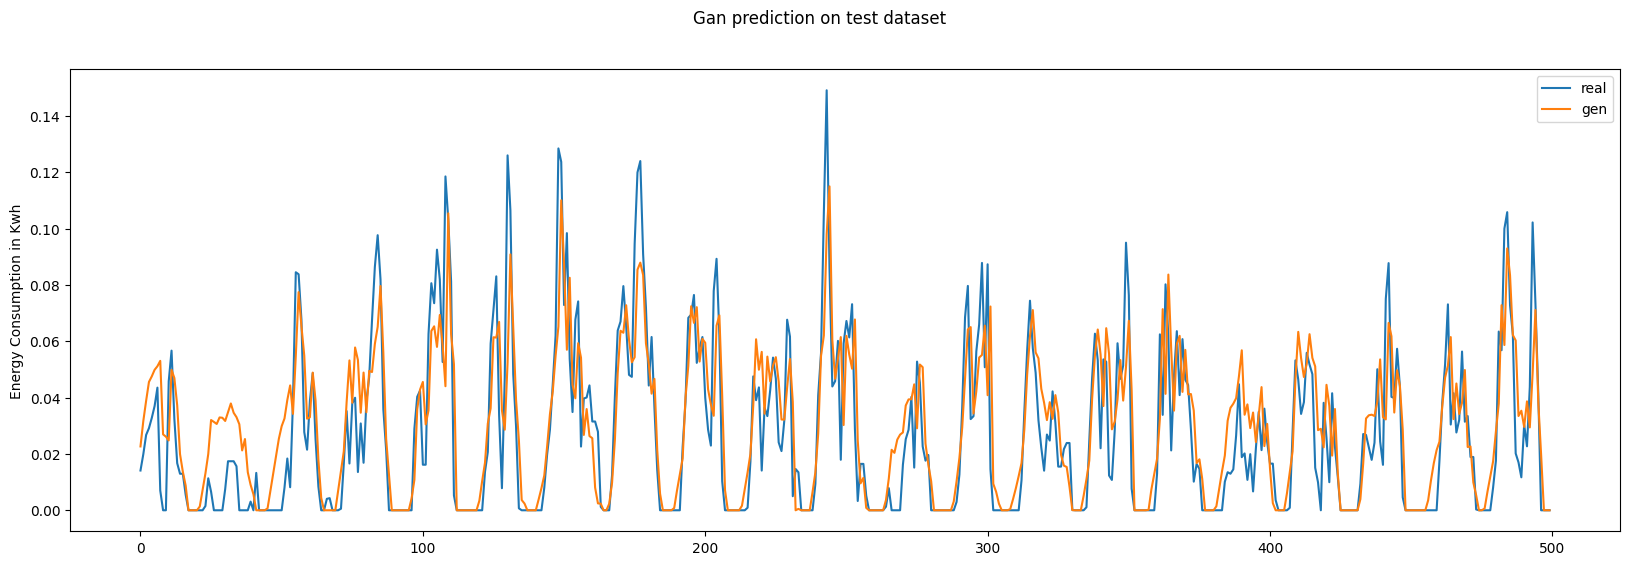

In [1655]:
plot_full_dataset(real_data_bilstm.detach().cpu().numpy(), predicted_data_bilstm.detach().cpu().numpy(), 000, 500, 'Results/test3.png', 0)

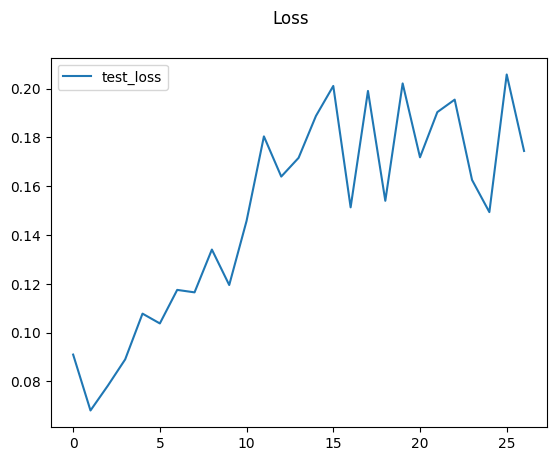

In [1656]:
mlt.suptitle('Loss')
#mlt.plot(errors_generator, label='train_loss')
mlt.plot(loss_bilstm[:], label='test_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

In [1657]:
validation_matrix_forecasting(real_data_bilstm.detach().cpu().numpy(), predicted_data_bilstm.detach().cpu().numpy(), 0)

RMSE:0.02410895749926567
MAE: 0.01883059
MSE: 0.00058124185
R-squared: 0.5149210056406297


# Vanilla LSTM

In [1677]:
hidden_size = 14
model = vanilla_LSTM(input_size, hidden_size, 1).to(device)
#model = Seq2SeqAttention(input_size, hidden_size, input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.0001)
loss_function_seq2seq = nn.MSELoss()

In [1678]:
real_dataset_vanilla_lstm, gen_dataset_vanilla_lstm, errors_generator_vanilla_lstm = train_vanilla_lstm(model, optimizer, loss_function_seq2seq, data_train, ground_truth_train, step_per_epoch)

Epoch: 0 Loss G.: 1.8759477138519287
Epoch: 1 Loss G.: 2.035069704055786
Epoch: 2 Loss G.: 2.1764883995056152
Epoch: 3 Loss G.: 0.824906051158905
Epoch: 4 Loss G.: 0.5149001479148865
Epoch: 5 Loss G.: 0.46148666739463806
Epoch: 6 Loss G.: 0.4397370219230652
Epoch: 7 Loss G.: 0.4415137469768524
Epoch: 8 Loss G.: 0.452203631401062
Epoch: 9 Loss G.: 0.4946648180484772
Epoch: 10 Loss G.: 0.5273681282997131
Epoch: 11 Loss G.: 0.5437073707580566
Epoch: 12 Loss G.: 0.5140786170959473
Epoch: 13 Loss G.: 0.4108041822910309
Epoch: 14 Loss G.: 0.3453364968299866
Epoch: 15 Loss G.: 0.303360253572464
Epoch: 16 Loss G.: 0.2653082311153412
Epoch: 17 Loss G.: 0.2360774427652359
Epoch: 18 Loss G.: 0.21596281230449677
Epoch: 19 Loss G.: 0.19991187751293182
Epoch: 20 Loss G.: 0.19043023884296417
Epoch: 21 Loss G.: 0.18227259814739227
Epoch: 22 Loss G.: 0.17832519114017487
Epoch: 23 Loss G.: 0.17390823364257812
Epoch: 24 Loss G.: 0.17259377241134644
Epoch: 25 Loss G.: 0.1714661419391632
Epoch: 26 Loss G.:

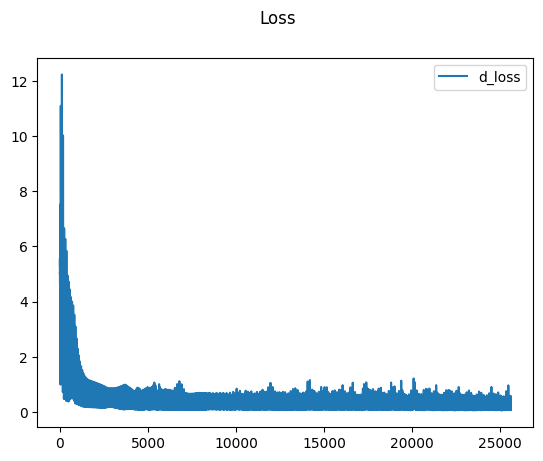

In [1679]:
mlt.suptitle('Loss')
mlt.plot(errors_generator_vanilla_lstm, label='d_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

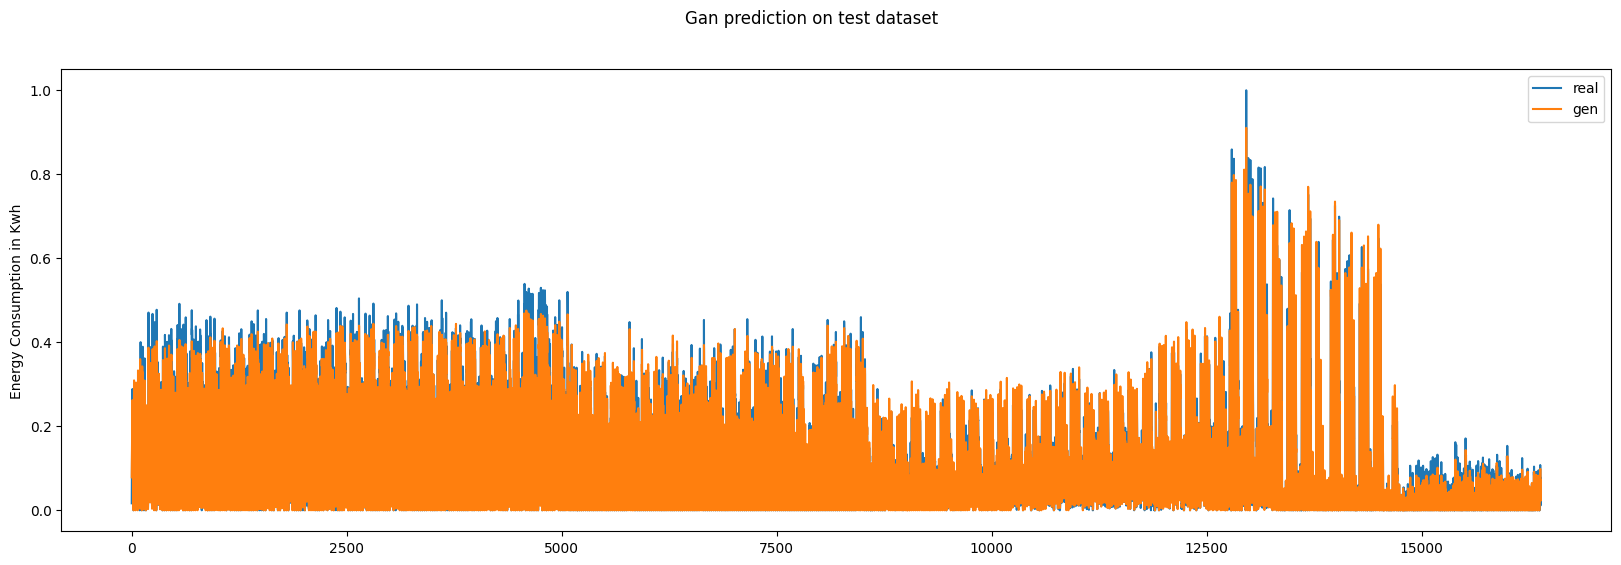

In [1680]:
plot_full_dataset(real_dataset_vanilla_lstm[:].detach().cpu().numpy(), gen_dataset_vanilla_lstm[:].detach().cpu().numpy(), 00, 50000, 'Results/test1.png', 0)

In [1359]:
df = pd.read_csv("../Data/Processed/perth_data_with_zero.csv")
#df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
df['Hour'] = pd.to_datetime(df['Start']).dt.hour
df.drop(columns=['Start'], inplace=True)
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Hour'])

In [1360]:
_, data_test, _, ground_truth_test = get_train_test_dataset_forecasting(df, train_ratio)

In [1681]:
data_test = data_test[: -(data_test.shape[0] % batch_size)]
ground_truth_test = ground_truth_test[: -(ground_truth_test.shape[0] % batch_size)]

In [1682]:
step_per_epoch = len(data_test) // batch_size

In [1683]:
data_test = torch.from_numpy(data_test).float().to(device)
ground_truth_test = torch.from_numpy(ground_truth_test).float().to(device)

In [1684]:
real_data_lstm, predicted_data_lstm, loss_lstm = test_model(model, data_test, ground_truth_test, loss_function_seq2seq, step_per_epoch)

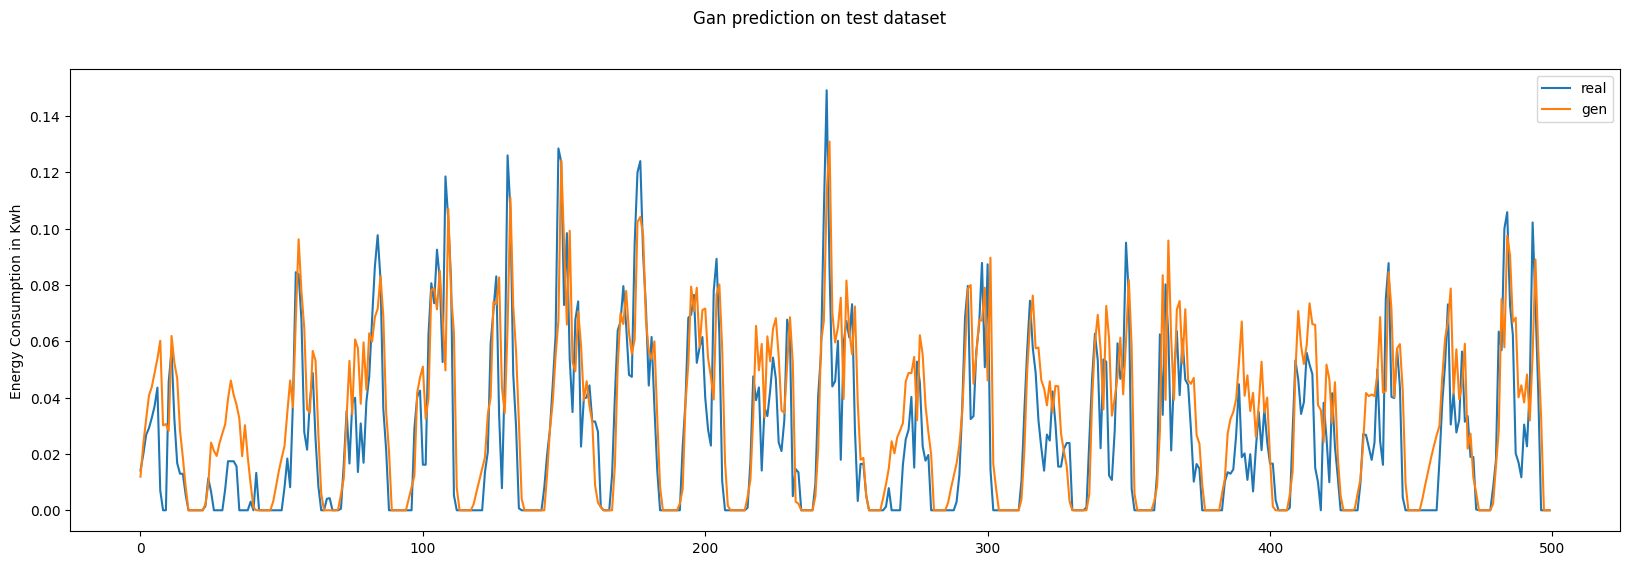

In [1685]:
plot_full_dataset(real_data_lstm.detach().cpu().numpy(), predicted_data_lstm.detach().cpu().numpy(), 000, 500, 'Results/test3.png', 0)

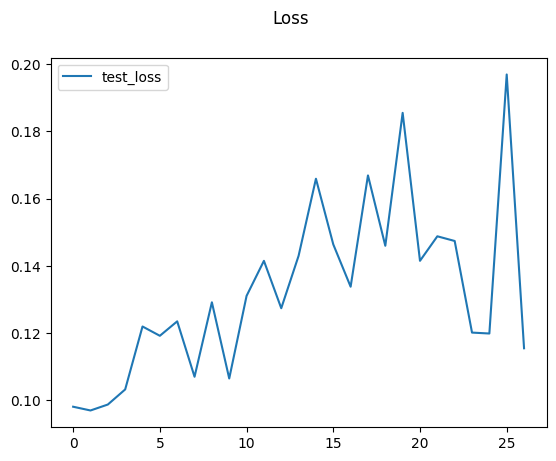

In [1686]:
mlt.suptitle('Loss')
#mlt.plot(errors_generator, label='train_loss')
mlt.plot(loss_lstm[:], label='test_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

In [1687]:
validation_matrix_forecasting(real_data_lstm.detach().cpu().numpy(), predicted_data_lstm.detach().cpu().numpy(), 0)

RMSE:0.02271425351500511
MAE: 0.017109036
MSE: 0.0005159373
R-squared: 0.5694213995849655


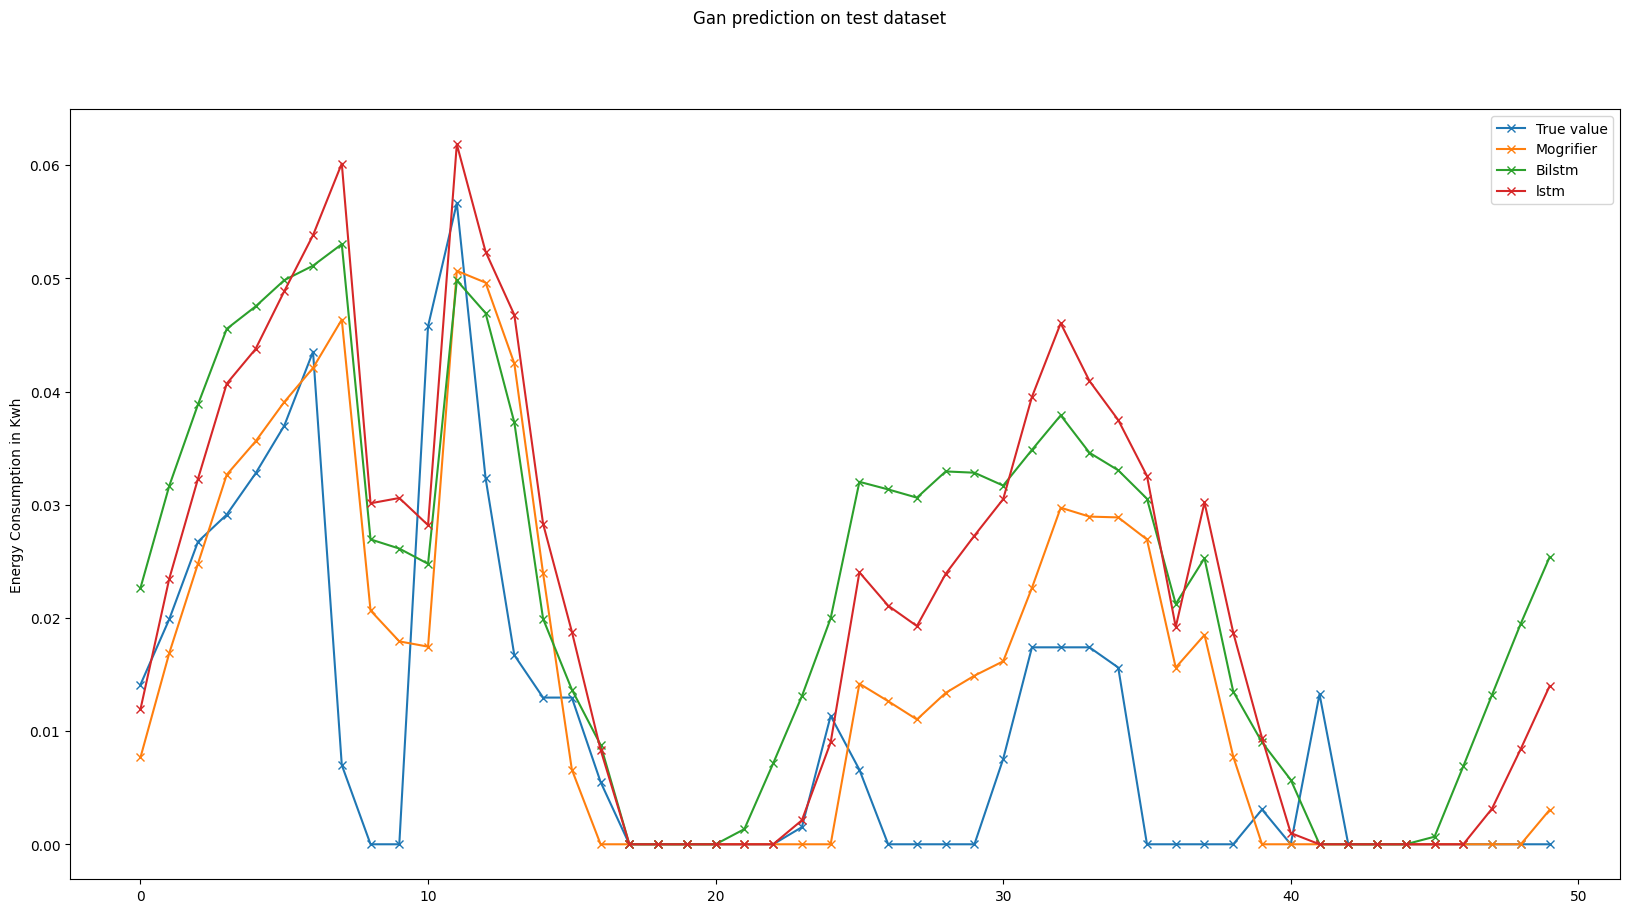

In [1699]:
compare_predicted_dataset(real_data_lstm.detach().cpu().numpy(), predicted_dataset_mogrifier.detach().cpu().numpy(), predicted_data_bilstm.detach().cpu().numpy(), predicted_data_lstm.detach().cpu().numpy(), 000, 50, 'Results/compare.png', 0)